# Extract photometric flux from spectra with HAWC+ filters

## Read in SOFIA/HAWC+ filters

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

In [17]:
filter_dir = '/Users/yaolun/astro_tools/sofia_filters/hawc+/'
band = ['bandA','bandB','bandC','bandD','bandE']
central_wave = [53., 63., 89., 154., 214.]  

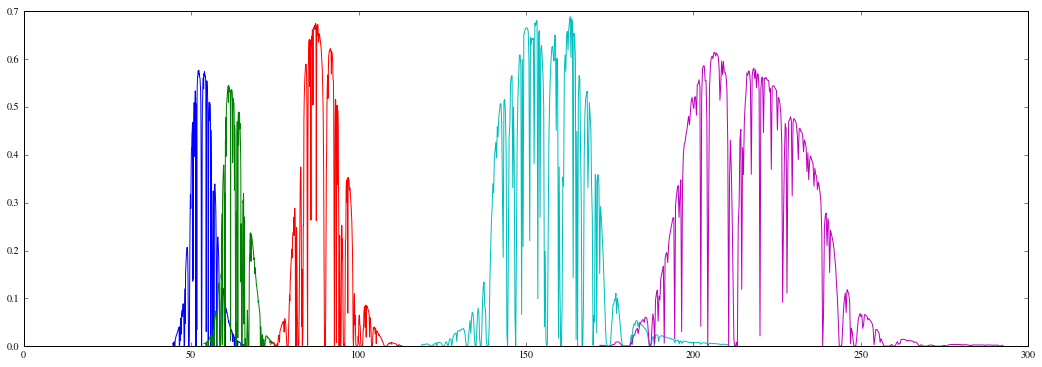

In [35]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
for b in band:
    data = ascii.read(filter_dir+b+'.txt', data_start=2)
    ax.plot(data['Wavelength'], data['Tot.Trans.'])

## Read in the observations

In [25]:
# micron, Jy
spitzer = ascii.read('/Users/yaolun/bhr71/best_calibrated/bhr71_spitzer_irs.txt',
                     header_start=None, data_start=3, names=['Wavelength','Flux_Density','Error'])
pacs = ascii.read('/Users/yaolun/bhr71/best_calibrated/BHR71_pacs_weighted_continuum.txt')
spire = ascii.read('/Users/yaolun/bhr71/best_calibrated/BHR71_spire_corrected_continuum.txt')

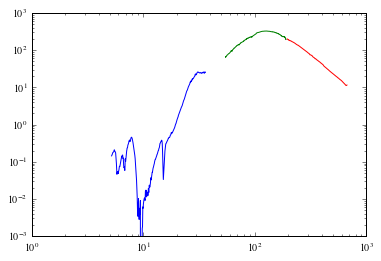

In [28]:
plt.plot(spitzer['Wavelength'], spitzer['Flux_Density'])
plt.plot(pacs['Wavelength(um)'], pacs['Flux_Density(Jy)'])
plt.plot(spire['Wavelength(um)'], spire['Flux_Density(Jy)'])

plt.xscale('log')
plt.yscale('log')

### Combine all spectra and create an interpolated spectrum object

In [52]:
wave_tot = np.hstack((spitzer['Wavelength'],
                      pacs['Wavelength(um)'],
                      spire['Wavelength(um)']))
flux_tot = np.hstack((spitzer['Flux_Density'],
                      pacs['Flux_Density(Jy)'],
                      spire['Flux_Density(Jy)']))
# sort
sorter = np.argsort(wave_tot)
wave_tot = wave_tot[sorter]
flux_tot = wave_tot[sorter]

# convert the flux unit from Jy to F_lambda (erg/s/cm2/um)
import astropy.constants as const
c = const.c.cgs.value

fnu2fl = 1e-23*c/(wave_tot*1e-4)/wave_tot
flux_tot = flux_tot * fnu2fl

from scipy.interpolate import interp1d
flux_interp = interp1d(wave_tot, flux_tot)

### Choose the desired filters

In [74]:
i = 0
fil = ascii.read(filter_dir+band[i]+'.txt', data_start=2)

In [75]:
flux = np.trapz(flux_interp(fil['Wavelength'])*fil['Tot.Trans.'],x=fil['Wavelength'] )
print central_wave[i], 'um', flux, 'erg/s/cm2'

53.0 um 2.21826103284e-10 erg/s/cm2


### Aperture size

In [70]:
area = np.pi*(31.8/2)**2

In [71]:
print central_wave[i], 'um', flux/area, 'erg/s/cm2/as2'

154.0 um 3.70500283651e-13 erg/s/cm2/as2


In [73]:
print central_wave[i], 'um', flux/area/33.88, 'erg/s/cm2/um/as2'

154.0 um 1.09356636261e-14 erg/s/cm2/um/as2
